In [27]:
import phoebe
import numpy as np
from spice.spectrum import simulate_observed_flux
from transformer_payne import Blackbody
from phoebe.parameters.dataset import _mesh_columns
import astropy.units as u
%matplotlib inline
from tqdm import tqdm

from jax import config
config.update('jax_platform_name', 'cpu')
config.update("jax_enable_x64", False)

In [ ]:
b = phoebe.default_binary()
times = np.linspace(0, 1, 10)
COLUMNS = _mesh_columns
b.add_dataset('mesh', times=times, columns=COLUMNS, dataset='mesh01')
b.add_dataset('orb', compute_times=times, dataset='orb01')
b.add_dataset('lc', compute_times=times, passband='Johnson:V', dataset='lc01')
b.set_value_all('ld_mode', 'manual')
b.set_value_all('ld_func', 'linear')
b.set_value_all('ld_coeffs', [0.])
b.set_value_all('ld_mode_bol', 'manual')
b.set_value_all('ld_func_bol', 'linear')
b.set_value_all('ld_coeffs_bol', [0.])
b.set_value_all('atm', 'blackbody')
b.set_value('sma@binary', 2*u.AU.to(u.solRad))
# b.set_value('distance', 10*u.pc.to(u.solRad))
b.run_compute(irrad_method='none', coordinates='uvw', ltte=False)

In [3]:
b.get_parameter('passband')

<Parameter: passband=Johnson:V | keys: description, choices, value, visible_if, copy_for, readonly, advanced, latexfmt>

### Verify the velocities

In [4]:
bb = Blackbody()

In [5]:
from spice.models.binary import PhoebeBinary
from spice.models.phoebe_utils import PhoebeConfig
import matplotlib.pyplot as plt

p1 = PhoebeConfig(b, 'mesh01', 'orb01')
pb = PhoebeBinary.construct(p1, bb.parameter_names, {pn: sp for pn, sp in zip(bb.parameter_names, bb.solar_parameters)})

In [6]:
from spice.models.binary import evaluate_orbit
pbs = [evaluate_orbit(pb, t) for t in tqdm(times)]

100%|██████████| 10/10 [00:00<00:00, 15.38it/s]


In [7]:
pb1, pb2 = pbs[0]
spice_orbit_velocities = np.stack([pb.orbital_velocity for pb, _ in pbs]).T

In [8]:
orbit_velocities = np.stack([
    b.get_parameter('vus@primary@orb01').value,
    b.get_parameter('vvs@primary@orb01').value,
    b.get_parameter('vws@primary@orb01').value
    ])

In [9]:
b.get_parameter('ws@primary', time=0.0)

<Parameter: ws=[-2.71955396 -2.65000569 -2.5804573  ... -1.90785824
 -1.86507474 -1.84268871] solRad | keys: description, value, default_unit, visible_if, required_shape, copy_for, readonly, advanced, latexfmt>

In [10]:
pb1.center

array([ 1.62265701e-16,  1.62265701e-16, -2.65000000e+00])

In [11]:
np.all(np.isclose(spice_orbit_velocities, orbit_velocities))

True

In [12]:
spice_element_velocities = np.stack([pb.velocities.T for pb, _ in pbs])
element_velocities = np.stack([
    np.stack([
        b.get_parameter('vus@primary', time=t).value,
        b.get_parameter('vvs@primary', time=t).value,
        b.get_parameter('vws@primary', time=t).value
    ])
    for t in times
])

In [13]:
np.all(np.isclose(spice_element_velocities, element_velocities))

True

In [14]:
element_velocities.shape

(10, 3, 1740)

In [15]:
ws = np.linspace(900, 40000, 1000)
s1s = [simulate_observed_flux(bb.intensity, pb1, np.log10(ws), disable_doppler_shift=False) for pb1, _ in pbs]
s2s = [simulate_observed_flux(bb.intensity, pb2, np.log10(ws), disable_doppler_shift=False) for _, pb2 in pbs]

s1s_no_d = [simulate_observed_flux(bb.intensity, pb1, np.log10(ws), disable_doppler_shift=True) for pb1, _ in pbs]
s2s_no_d = [simulate_observed_flux(bb.intensity, pb2, np.log10(ws), disable_doppler_shift=True) for _, pb2 in pbs]

In [16]:
diffs_phoebe = -2.5*np.log10(b.get_parameter('fluxes@lc01@model').value)

In [17]:
from spice.spectrum import AB_passband_luminosity
from spice.spectrum.filter import JohnsonV

In [18]:
bolometric = JohnsonV()

In [19]:
lums = [AB_passband_luminosity(bolometric, ws, s1[:, 0]+s2[:, 0]) for s1, s2 in zip(s1s, s2s)]
lums_no_d = [AB_passband_luminosity(bolometric, ws, s1[:, 0]+s2[:, 0]) for s1, s2 in zip(s1s_no_d, s2s_no_d)]

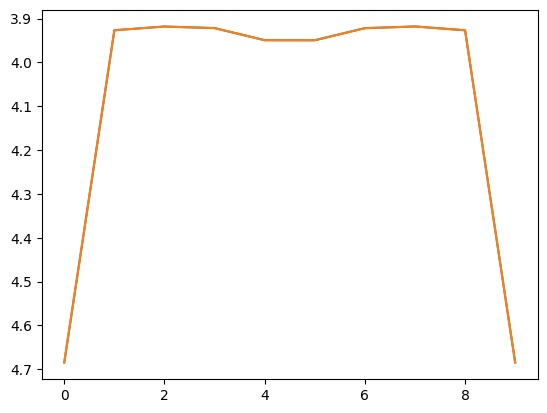

In [20]:
plt.plot(lums)
plt.plot(lums_no_d)
plt.gca().invert_yaxis()

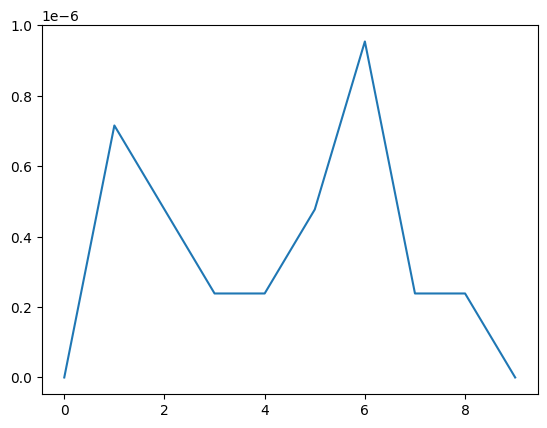

In [21]:
residuals = np.abs(np.array(lums)-np.array(lums_no_d))
plt.plot(residuals)
plt.show()

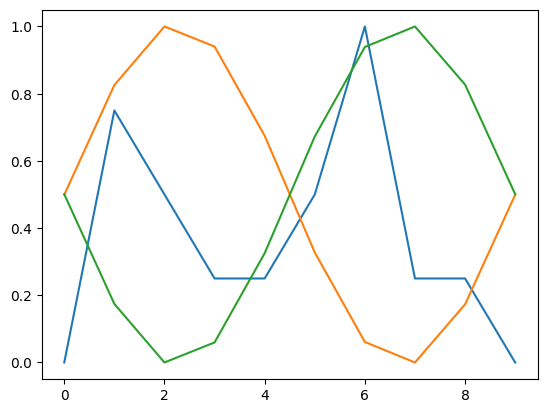

In [22]:
residuals = np.abs(np.array(lums)-np.array(lums_no_d))
plt.plot((residuals - np.min(residuals)) / (np.max(residuals) - np.min(residuals)))
vels1 = [np.mean(pb1.los_velocities) for pb1, _ in pbs]
vels2 = [np.mean(pb1.los_velocities) for _, pb1 in pbs]
plt.plot((vels1 - np.min(vels1)) / (np.max(vels1) - np.min(vels1)))
plt.plot((vels2 - np.min(vels2)) / (np.max(vels2) - np.min(vels2)))

In [23]:
diffs_phoebe = diffs_phoebe-diffs_phoebe[0]
diffs_spice = np.array(lums)-lums[0]

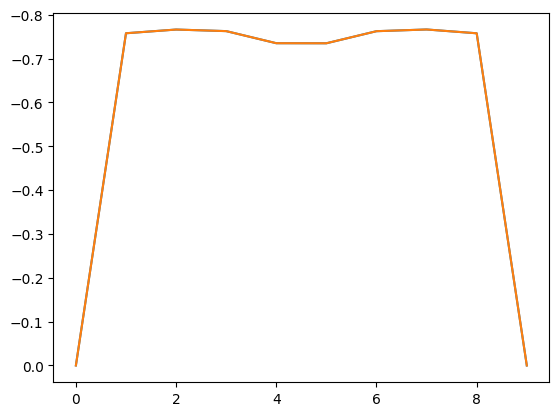

In [24]:
plt.plot(diffs_phoebe)
plt.plot(diffs_spice)
plt.gca().invert_yaxis()
plt.gca()
plt.show()

    0.0035
0.0035

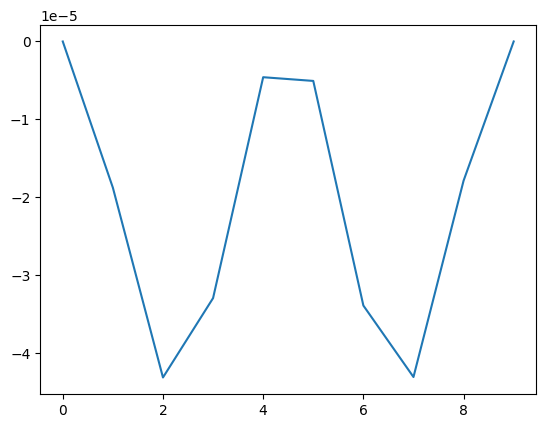

In [25]:
plt.plot(diffs_phoebe-diffs_spice)
plt.show()

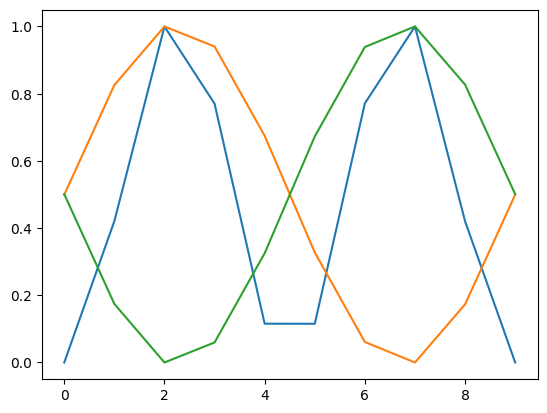

In [23]:
residuals = np.abs(diffs_phoebe-diffs_spice)
plt.plot((residuals - np.min(residuals)) / (np.max(residuals) - np.min(residuals)))
vels1 = [np.mean(pb1.los_velocities) for pb1, _ in pbs]
vels2 = [np.mean(pb1.los_velocities) for _, pb1 in pbs]
plt.plot((vels1 - np.min(vels1)) / (np.max(vels1) - np.min(vels1)))
plt.plot((vels2 - np.min(vels2)) / (np.max(vels2) - np.min(vels2)))

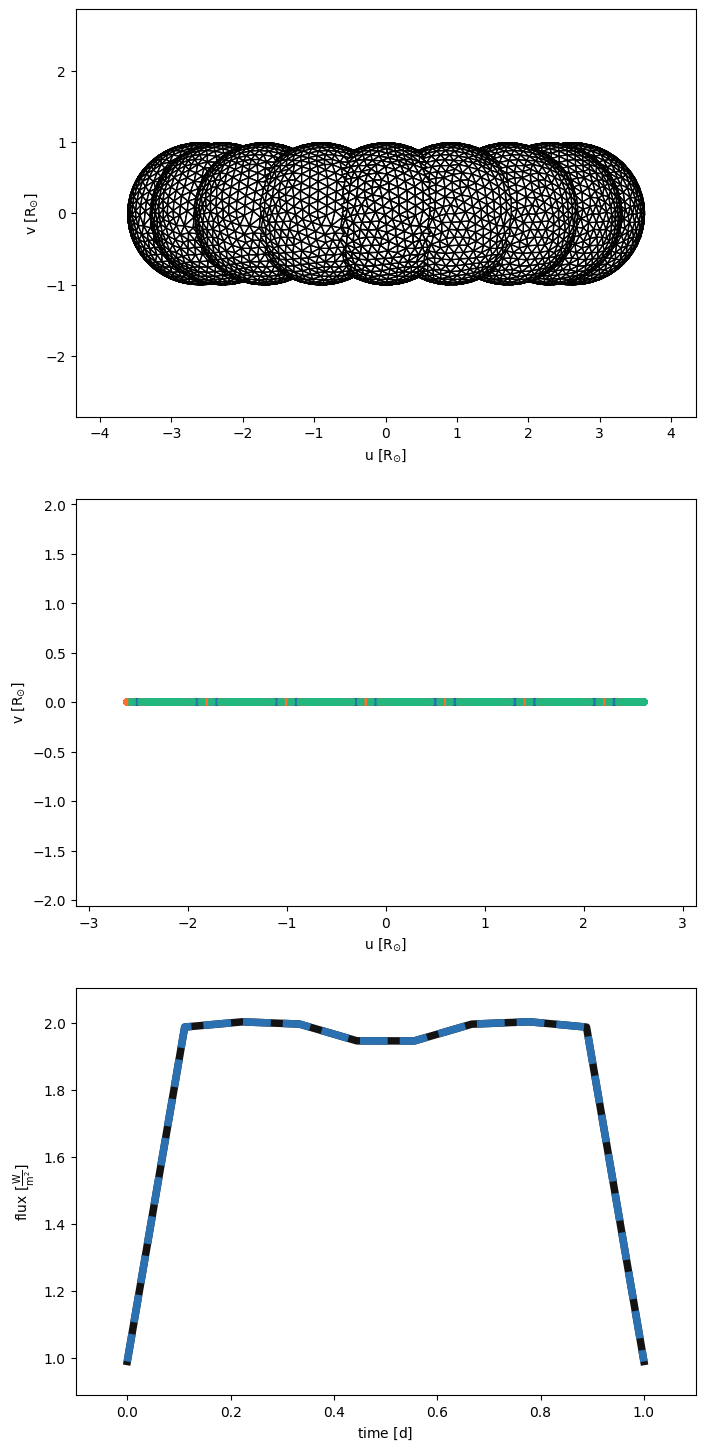

(<autofig.figure.Figure | 3 axes | 46 call(s)>,
 <Figure size 800x1800 with 3 Axes>)

In [25]:
b.plot(show=True)